# Porównywanie funkcji skrótu
W tym sprawozdaniu będziemy porównywać trzy funkcje skrótu: md5, sha256 oraz sha384. Funkcje te służą do generowania krótkiego, stałego i unikalnego kodu dla dowolnego ciągu danych. Są one szeroko stosowane w informatyce, między innymi do weryfikacji integralności plików i haseł. Celem naszego porównania będzie zbadanie, która funkcja skrótu zapewnia najwyższy poziom bezpieczeństwa i skuteczności. W tym celu przetestujemy te funkcje na różnych rodzajach danych, takich jak krótkie i długie ciągi znaków oraz pliki o różnych rozmiarach. Wszystkie testy zostaną wykonane w języku Python z wykorzystaniem biblioteki hashlib.



### Importowanie bibliotek
Ten fragment kodu importuje bibliotekę hashlib, bibliotekę os, bibliotekę time oraz bibliotekę matplotlib.pyplot.

- hashlib jest biblioteką, która umożliwia generowanie funkcji skrótu.
- os jest biblioteką, która udostępnia wiele funkcji związanych z systemem operacyjnym, takich jak np. operacje na plikach i katalogach.
- time to biblioteka, która umożliwia operowanie czasem.
- random to biblioteka, która służy do generowania liczb pseudolosowych.
- string to biblioteka, która zawiera narzędzia do zarządzania tekstem.
- matplotlib.pyplot to biblioteka, która umożliwia tworzenie wykresów i grafik.
- prettytable to biblioteka, która służy do wyświetlania tabel w konsoli

In [53]:
import hashlib
import os
import time
import random
import string
import matplotlib.pyplot as plt
from prettytable import PrettyTable

---

### Tworzenie plików
Tworzymy trzy pliki o rozmiarach 1, 5 i 10 megabajtów w katalogu "files". Funkcja create_file służy do generowania plików o określonym rozmiarze, a następnie jest wywoływana trzy razy w pętli for z argumentami 1, 5 i 10, aby utworzyć trzy pliki o różnych rozmiarach. Dodatkowo w funkcji create_file istnieje opcjonalny argument "amount_1_bin", który służy do zdefiniowania, ile znaków o 1 bicie pojawi się w pliku wynikowym.

In [3]:
file_samples = [1, 5, 10]
files_directory = 'files'

def create_file(size_in_mb, directory=files_directory, amount_1_bin=0):
    size_in_bytes = size_in_mb * 1024 * 1024

    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(f'{directory}/{size_in_mb}MB.txt', 'wb') as f:
        f.write(b'\0' * (size_in_bytes - amount_1_bin))
        f.write(b'\1' * amount_1_bin)

for sample in file_samples:
    create_file(sample)

---

### Wyliczanie czasów działania algorytmów
Liczymy czas, jaki zajmuje poszczególnym algorytmom na skrócenie każdego z trzech plików. Każdy pomiar wykonujemy 30 razy i go uśredniamy w celu zachowania transparentności wyników.

In [4]:
def calculate_hash_time(samples, algorithm):
    sample_times = []
    for sample in samples:
        with open(f'{files_directory}/{sample}MB.txt', 'rb') as f:
            start = time.time()
            hash_obj = algorithm(f.read())
            end = time.time()

            sample_times.append(end - start)

    return list(zip(samples, sample_times))

def calculate_avg_time(samples, algorithm, acc):
    times = [0] * len(samples)
    for _ in range(acc):
        hash_time = calculate_hash_time(samples, algorithm)
        hash_time_list = [element[1] for element in hash_time]
        times = [a + b for a, b in zip(times, hash_time_list)]

    return [hash_time / acc for hash_time in times]

md5_time = calculate_avg_time(file_samples, hashlib.md5, 30)
sha256_time = calculate_avg_time(file_samples, hashlib.sha256, 30)
sha384_time = calculate_avg_time(file_samples, hashlib.sha384, 30)

---

### Rysowanie wykresu
Rysujemy wykres wykorzystując wcześniej zebrane dane.

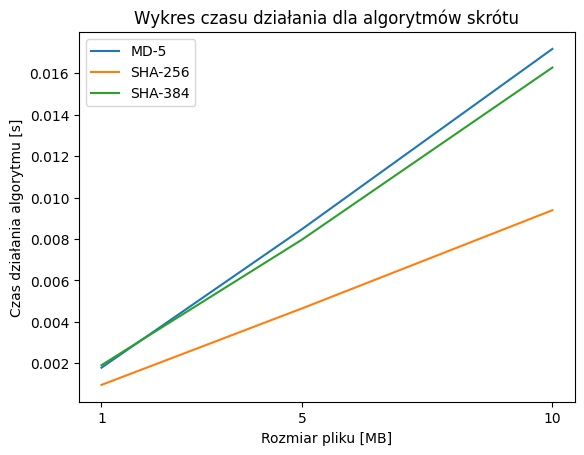

In [5]:
x = file_samples.copy()

plt.plot(x, md5_time, label="MD-5")
plt.plot(x, sha256_time, label="SHA-256")
plt.plot(x, sha384_time, label="SHA-384")

plt.xticks(x)
plt.xlabel('Rozmiar pliku [MB]')
plt.ylabel('Czas działania algorytmu [s]')
plt.title('Wykres czasu działania dla algorytmów skrótu')
plt.legend()
plt.show()

Jak widać, najszybciej radzi sobie algorytm SHA-256. Nieco wolniej radzą sobie algorytmy SHA-384 oraz MD-5.

Algorytmy SHA-384 i SHA-256 są oparte na tej samej konstrukcji, a różnią się jedynie długością wyniku (384 bity dla SHA-384 i 256 bitów dla SHA-256). Jednak SHA-384 wykonuje więcej rund obliczeń (80 rund) niż SHA-256 (64 rundy), co przekłada się na zwiększenie złożoności obliczeniowej. Dodatkowo SHA-384 korzysta z większych wartości początkowych i używa większych kluczy podczas przetwarzania danych wejściowych, co również wpływa na zwiększenie złożoności obliczeniowej.

---

### Analiza skrótów po zmianie jednego bitu
Dla każdego algorytmu oraz rozmiaru pliku sprawdzamy, jak wygląda skrót dla plików wypełnionych zerowymi bitami. Następnie sprawdzamy, jak wygląda skrót dla plików, które różnią się tylko jednym bitem na ostatniej pozycji względem wcześniejszych plików. Sprawdzamy jaki procent bitów się zmienił. Wyniki przedstawione zostały w tabeli.

In [6]:
def compare_hashes(samples, algorithm):
    hashes = []
    for sample in samples:
        create_file(sample)
        with open(f'{files_directory}/{sample}MB.txt', 'rb') as f:
            hash_obj_0 = algorithm(f.read())
            hash_0 = hash_obj_0.hexdigest()

        create_file(sample, amount_1_bin=1)
        with open(f'{files_directory}/{sample}MB.txt', 'rb') as f:
            hash_obj_1 = algorithm(f.read())
            hash_1 = hash_obj_1.hexdigest()

        hashes.append((sample, hash_0, hash_1))

    return hashes

def hex_to_bin(hex_str):
    hex_num = int(hex_str, 16)
    binary_str = bin(hex_num)[2:].zfill(len(hex_str) * 4)
    return [int(b) for b in binary_str]

def hash_difference_per(data_set_1, data_set_2):
    data_set = zip(hex_to_bin(data_set_1), hex_to_bin(data_set_2))
    difference_counter = sum([1 for x, y in data_set if x != y])

    return (difference_counter / len(hex_to_bin(data_set_1))) * 100


table = PrettyTable()
table.field_names = ["Nazwa algorytmu"] + [f"Zmienione bity (%) dla pliku {element}MB" for element in file_samples]

md5_hashes = compare_hashes(file_samples, hashlib.md5)
table.add_row(["MD5"] + [f"{round(hash_difference_per(x, y), 4)}%" for _, x, y in md5_hashes])

sha256_hashes = compare_hashes(file_samples, hashlib.sha256)
table.add_row(["SHA256"] + [f"{round(hash_difference_per(x, y), 4)}%" for _, x, y in sha256_hashes])

sha384_hashes = compare_hashes(file_samples, hashlib.sha384)
table.add_row(["SHA384"] + [f"{round(hash_difference_per(x, y), 4)}%" for _, x, y in sha384_hashes])

print(table.get_string())

+-----------------+----------------------------------+----------------------------------+-----------------------------------+
| Nazwa algorytmu | Zmienione bity (%) dla pliku 1MB | Zmienione bity (%) dla pliku 5MB | Zmienione bity (%) dla pliku 10MB |
+-----------------+----------------------------------+----------------------------------+-----------------------------------+
|       MD5       |              43.75%              |             42.9688%             |              54.6875%             |
|      SHA256     |             46.0938%             |             51.9531%             |              51.9531%             |
|      SHA384     |             49.7396%             |             48.9583%             |              48.9583%             |
+-----------------+----------------------------------+----------------------------------+-----------------------------------+


Wyniki przedstawione są w tabeli dla trzech różnych algorytmów skrótu: MD5, SHA256 i SHA384. Dla każdego algorytmu i rozmiaru pliku (1MB, 5MB i 10MB) podano procentowy udział zmienionych bitów.

Na podstawie wyników można wnioskować, że zmiana jednego bitu w pliku zwykle powoduje znaczącą zmianę w skrócie pliku. W przypadku algorytmów MD5 i SHA256 zmiana ta wynosi zwykle od około 40% do ponad 50%. W przypadku SHA384 zmiana ta jest nieco mniejsza i wynosi zwykle pomiędzy 48% a 50%.

Wyniki te są ważne z punktu widzenia bezpieczeństwa systemów informatycznych. Oznacza to bowiem, że nawet drobna zmiana w pliku może wpłynąć na jego skrót i tym samym uniemożliwić potwierdzenie jego integralności przy użyciu danego algorytmu skrótu.

---

### Analiza kolizji dla algorytmów skrótu
Tworzymy losowo 500 i 1000 stringów o różnych długościach. Następnie dla każdego algorytmu skrótu tworzymy hash. Sprawdzamy w zbiorze, ile jest takich hashów, które mają takie same pierwsze 12 i 20 bitów. Wyniki prezentujemy w tabeli.

In [54]:
def create_random_hashes(n, algorithm):
    hashes = []
    for _ in range(n):
        rand_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=random.randint(10, 100)))
        hash_obj = algorithm(rand_string.encode("UTF-8"))
        hashes.append(hash_obj.hexdigest())

    return hashes

def get_n_first_bits_from_hash(n, hash_hex):
    bits = []
    for char in hash_hex:
        bits += [int(b) for b in bin(int(char, 16))[2:].zfill(4)]

    return "".join(map(str, bits[:n]))

def analyze_algorithm(algorithm, first_bits, acc):
    random_hashes = create_random_hashes(acc, algorithm)
    hashes_first_bits = []
    for random_hash in random_hashes:
        hashes_first_bits.append(get_n_first_bits_from_hash(first_bits, random_hash))

    hashes_first_bits_set = set(hashes_first_bits)

    return len(hashes_first_bits) - len(hashes_first_bits_set)


table = PrettyTable()
table.field_names = ["Algorytm", "12 bitów dla 500 hashy", "12 bitów dla 1000 hashy", "20 bitów dla 500 hashy", "20 bitów dla 1000 hashy"]
table.add_row(["MD5",
                f"{analyze_algorithm(hashlib.md5, 12, 500)} powtórzeń",
                f"{analyze_algorithm(hashlib.md5, 12, 1000)} powtórzeń",
                f"{analyze_algorithm(hashlib.md5, 20, 500)} powtórzeń",
                f"{analyze_algorithm(hashlib.md5, 20, 1000)} powtórzeń"])

table.add_row(["SHA256",
               f"{analyze_algorithm(hashlib.sha256, 12, 500)} powtórzeń",
               f"{analyze_algorithm(hashlib.sha256, 12, 1000)} powtórzeń",
               f"{analyze_algorithm(hashlib.sha256, 20, 500)} powtórzeń",
               f"{analyze_algorithm(hashlib.sha256, 20, 1000)} powtórzeń"])

table.add_row(["SHA384",
               f"{analyze_algorithm(hashlib.sha384, 12, 500)} powtórzeń",
               f"{analyze_algorithm(hashlib.sha384, 12, 1000)} powtórzeń",
               f"{analyze_algorithm(hashlib.sha384, 20, 500)} powtórzeń",
               f"{analyze_algorithm(hashlib.sha384, 20, 1000)} powtórzeń"])

print(table.get_string())

+----------+------------------------+-------------------------+------------------------+-------------------------+
| Algorytm | 12 bitów dla 500 hashy | 12 bitów dla 1000 hashy | 20 bitów dla 500 hashy | 20 bitów dla 1000 hashy |
+----------+------------------------+-------------------------+------------------------+-------------------------+
|   MD5    |      24 powtórzeń      |      108 powtórzeń      |      0 powtórzeń       |       1 powtórzeń       |
|  SHA256  |      25 powtórzeń      |      111 powtórzeń      |      0 powtórzeń       |       0 powtórzeń       |
|  SHA384  |      29 powtórzeń      |      119 powtórzeń      |      0 powtórzeń       |       0 powtórzeń       |
+----------+------------------------+-------------------------+------------------------+-------------------------+


Na podstawie przedstawionych wyników, można zauważyć, że algorytmy skrótu MD5, SHA256 i SHA384 w przypadku pierwszych 12 bitów mają pewne kolizje. Dla 500 hashów MD5 ma 24 powtórzenia, a dla 1000 hashów - 108 powtórzeń. W przypadku SHA256 jest to odpowiednio 25 i 111 powtórzeń, a dla SHA384 - 29 i 119 powtórzeń.

Natomiast dla pierwszych 20 bitów, tylko MD5 ma jedno powtórzenie dla 1000 hashów, pozostałe algorytmy nie mają kolizji.

Należy jednak zauważyć, że 12 i 20 bitów to stosunkowo mała liczba bitów, które nie zapewniają dostatecznego poziomu bezpieczeństwa. W praktyce, do bezpiecznego skrótu danych zwykle używa się co najmniej 128-bitowych funkcji skrótu, takich jak SHA-256 czy SHA-512.

Podsumowując, wyniki tej analizy wskazują, że MD5, SHA256 i SHA384 mają pewne kolizje dla małych liczb bitów, ale nie mają one znaczącego wpływu na ich bezpieczeństwo w praktyce. Jednak dla większego poziomu bezpieczeństwa zaleca się używanie bardziej zaawansowanych funkcji skrótu.